In [1]:
%reset -f

In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Keras imports
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Conv2DTranspose, Dropout,Flatten,MaxPooling2D,Activation,LeakyReLU,Reshape,BatchNormalization
from keras.optimizers import RMSprop, Adam, sgd

/home/jonathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# make sure K.image_data_format data is set to 'channels last'
K.image_data_format()

'channels_last'

In [4]:
# prevent tensorflow from using up all of the GPU's memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [5]:
# importing data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

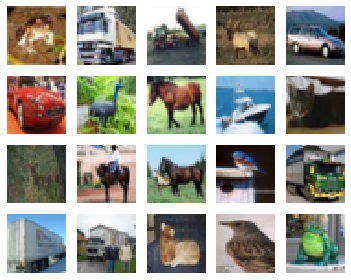

In [6]:
# display a sample of the mnist data
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


In [7]:
# Input noise to generator
def noise_creator(num_of_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(num_of_samples, sample_size))

In [8]:
# Generator function - take in one sample of random data
def generator(Z):
# create a sequential model
    model = Sequential()
    
    # Input and layer 1
    model.add(Dense(3072, input_shape = (100,)))
    model.add(Reshape(target_shape=(8,8,48)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # Conv 1
    model.add(Conv2DTranspose(32,kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # Conv 2
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    # model name
    model.name='generator'
    
    # print the structure of the model
    print(model.summary())
    
    # output of the model
    return model

In [9]:
# discriminator - takes in an image, outputs probability that it is real or fake
def discriminator(X):
# create a sequential model
    model = Sequential()
    
    # Conv 1
    model.add(Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape = (32,32,3)))
    model.add(LeakyReLU(alpha=0.01))
    
    # Conv 2
    model.add(Conv2D(16, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # Fully-connected layer
    model.add(Flatten())
    model.add(Dense(1024*3))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    
    # output
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    
    # model name 
    model.name='discriminator'
    
    # print the structure of the model
    print(model.summary())
    
    # output of the model
    return model

In [10]:
# setting whether the model is trainable (True) or not (False)        
def set_training_status(model, status):
    for layer in model.layers:
        layer.trainable = status


In [11]:
# preprocessing function for the mnist data 
def preprocess(x):
    x = x.reshape(-1,32,32,3)
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [12]:
# deprocessing function for viewing images
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(32, 32, 3)
    return x

In [13]:
# creating labels for the data
def make_labels(rows):
    return np.random.uniform(low=0.0, high=0.1, size=(rows,1)), \
    np.random.uniform(low=0.9, high=1.0, size=(rows,1))

In [14]:
# placeholder variables
Z_placeholder = K.placeholder(shape=(None,100))
X_placeholder = K.placeholder(shape=(32,32,3))

# declaring generator and discriminator
G_sample = generator(Z_placeholder)
D_sample = discriminator(X_placeholder)

# creating gan model with shared weights
gan = Sequential([
    G_sample,
    D_sample
])

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3072)              310272    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 48)          192       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        38432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

In [15]:
%%capture cap --no-stdout

# hyper parameters
sample_size = 100
batch_size = 128
eval_size = 16
epochs = 100
g_learning_rate = 0.0001
d_learning_rate = 0.001
g_beta = 0.5
d_beta = 0.5

# compiling the model
D_sample.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta), loss='binary_crossentropy')
gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta), loss='binary_crossentropy')


# variables for data
x_train_processed = preprocess(x_train)
x_test_processed = preprocess(x_test)

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

losses = []

# training for-loop
for e in range(epochs):
    for i in range(len(x_train_processed)//batch_size):
        # the real mnist images
        x_batch_real = x_train_processed[i * batch_size: (i+1)*batch_size]
        
        # noise samples and corresponding images created by generator
        noise_samples = noise_creator(batch_size, sample_size)
        x_batch_fake = G_sample.predict_on_batch(noise_samples)
        
        # training the discriminator to detect real and fake images
        set_training_status(D_sample, True)
        D_sample.train_on_batch(x_batch_real, y_train_real)
        D_sample.train_on_batch(x_batch_fake, y_train_fake)
        
        # training the generator (using the combined gan model)
        set_training_status(D_sample, False)
        gan.train_on_batch(noise_samples, y_train_real)
        
    # evaluate
    x_eval_real = x_train_processed[np.random.choice(len(x_train_processed), eval_size, replace=False)]
    
    noise_samples = noise_creator(eval_size, sample_size)
    x_eval_fake = G_sample.predict_on_batch(noise_samples)
        
    d_loss = D_sample.test_on_batch(x_eval_real, y_eval_real)
    d_loss += D_sample.test_on_batch(x_eval_fake, y_eval_fake)
    g_loss = gan.test_on_batch(noise_samples, y_eval_real) # want fakes to be realistic
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

Epoch:   1/100 Discriminator Loss: 3.9268 Generator Loss: 2.5668
Epoch:   2/100 Discriminator Loss: 2.9906 Generator Loss: 3.4723
Epoch:   3/100 Discriminator Loss: 2.0884 Generator Loss: 3.1011
Epoch:   4/100 Discriminator Loss: 2.5444 Generator Loss: 1.0793
Epoch:   5/100 Discriminator Loss: 1.1012 Generator Loss: 2.3382
Epoch:   6/100 Discriminator Loss: 2.2275 Generator Loss: 3.6189
Epoch:   7/100 Discriminator Loss: 3.2334 Generator Loss: 4.0174
Epoch:   8/100 Discriminator Loss: 1.4400 Generator Loss: 1.1334
Epoch:   9/100 Discriminator Loss: 3.4435 Generator Loss: 3.8375
Epoch:  10/100 Discriminator Loss: 5.2000 Generator Loss: 0.2262
Epoch:  11/100 Discriminator Loss: 4.1817 Generator Loss: 2.5372
Epoch:  12/100 Discriminator Loss: 1.9418 Generator Loss: 4.3138
Epoch:  13/100 Discriminator Loss: 11.8460 Generator Loss: 4.0027
Epoch:  14/100 Discriminator Loss: 3.8100 Generator Loss: 3.0086
Epoch:  15/100 Discriminator Loss: 1.9791 Generator Loss: 2.4609
Epoch:  16/100 Discrimin

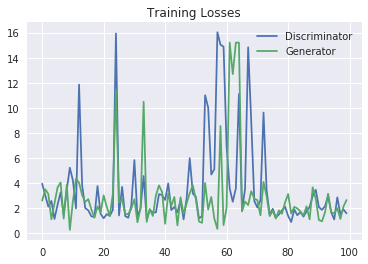

In [16]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

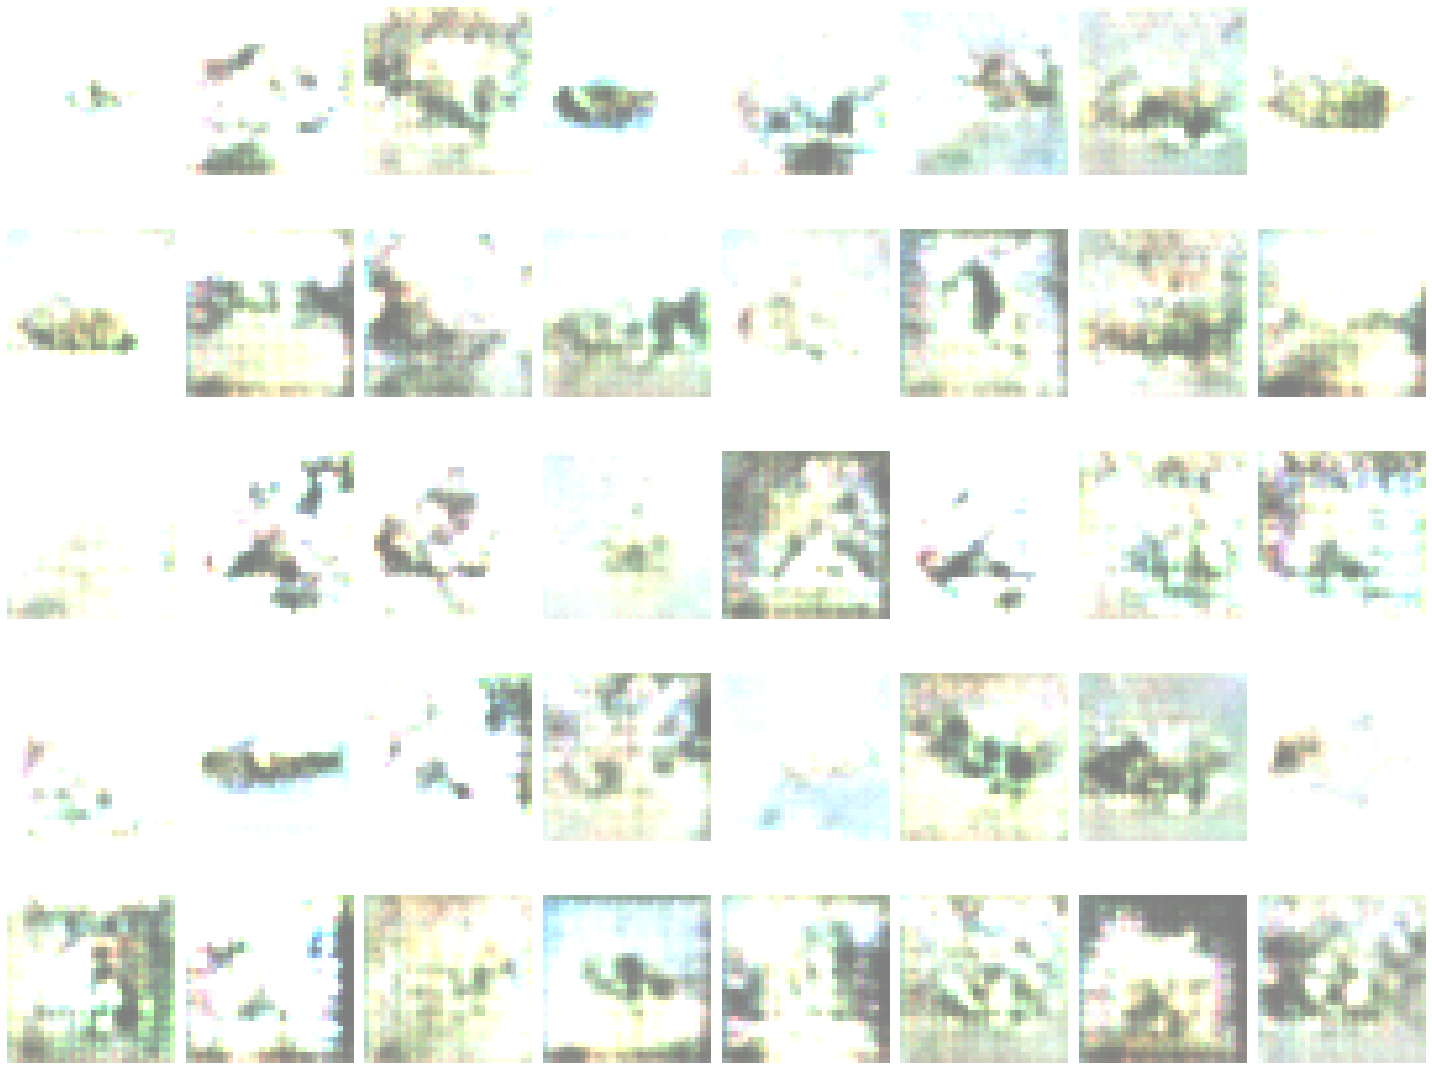

In [18]:
post_training_test = noise_creator(40,sample_size)
generated_cifar = G_sample.predict(post_training_test)

plt.figure(figsize=(20, 16))
for i in range(40):
    img = deprocess(generated_cifar[i])
    plt.subplot(5, 8, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()